In [1]:
from util import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import json
from math import isclose

sns.set(font_scale=1.5)

In [2]:
df_incremental = load_incremental()[["prefix","run","iteration",
        "incremental.healthy","incremental.timeout","incremental.total[ms]","incremental.sync[ms]","incremental.prop[ms]",
        "standalone.healthy", "standalone.timeout", "standalone.total[ms]", "standalone.sync[ms]", "standalone.prop[ms]",
        "problog.exitcode",   "problog.timeout",    "problog.total[ms]",
        "storm.healthy",      "storm.timeout",      "storm.total[ms]"
]]
df_incremental['standalone.engine[ms]'] = df_incremental['standalone.total[ms]'] -(df_incremental['standalone.sync[ms]'] +df_incremental["standalone.prop[ms]"])
df_incremental['incremental.engine[ms]']= df_incremental['incremental.total[ms]']-(df_incremental['incremental.sync[ms]']+df_incremental["incremental.prop[ms]"])

## Cummulative analysis time

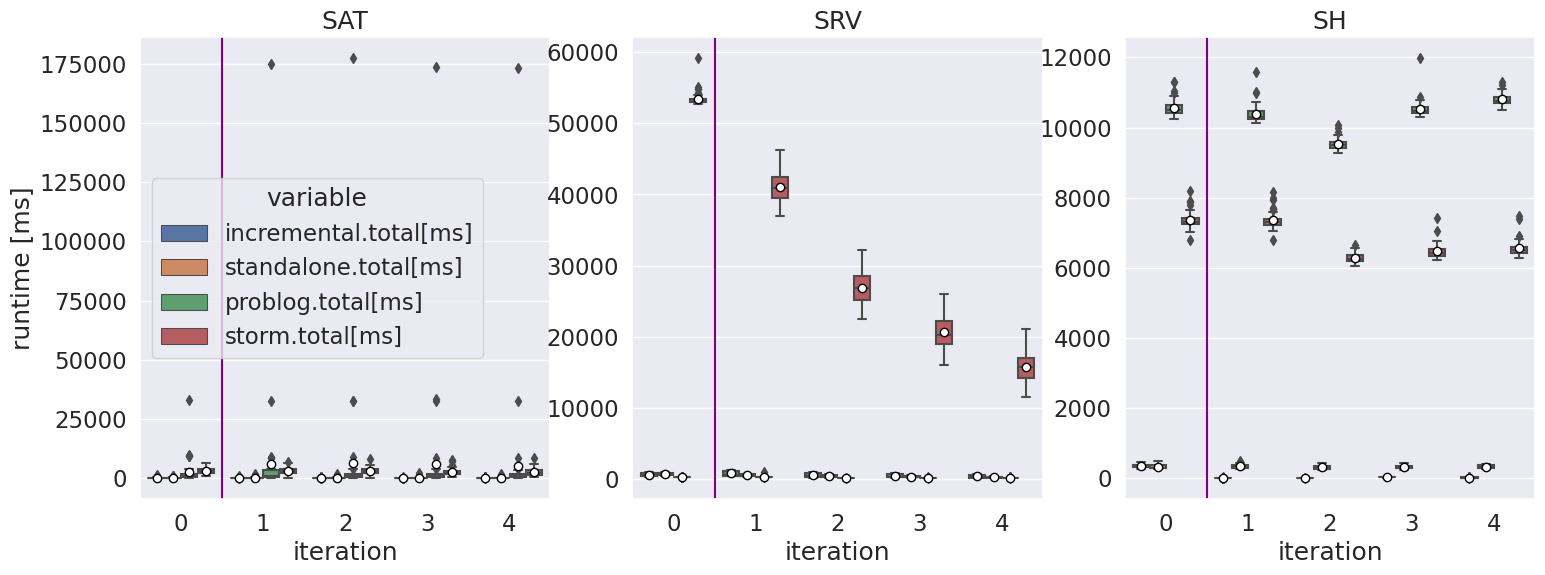

In [8]:
df = df_incremental
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=[
                 'incremental.total[ms]'
                ,'standalone.total[ms]'
                ,'problog.total[ms]'
                ,'storm.total[ms]'])
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}

def subplot(df, ax, case, ylabel=None, legend=False, dfx_name="iteration", dfy_name="value", hue="variable"):
    sns.boxplot(ax=ax, data=df[df['prefix']==case], x=dfx_name, y=dfy_name, hue=hue, showmeans=True, meanprops=meanprops)
    ax.set(title=case, ylabel=ylabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(0.5,0,1,color='purple')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle(None)

subplot(short, axes[0], 'SAT', 'runtime [ms]', True)
subplot(short, axes[1], 'SRV', None, False)
subplot(short, axes[2], 'SH', None, False)

fig.savefig("figures/incremental_detailed.pdf", bbox_inches='tight')

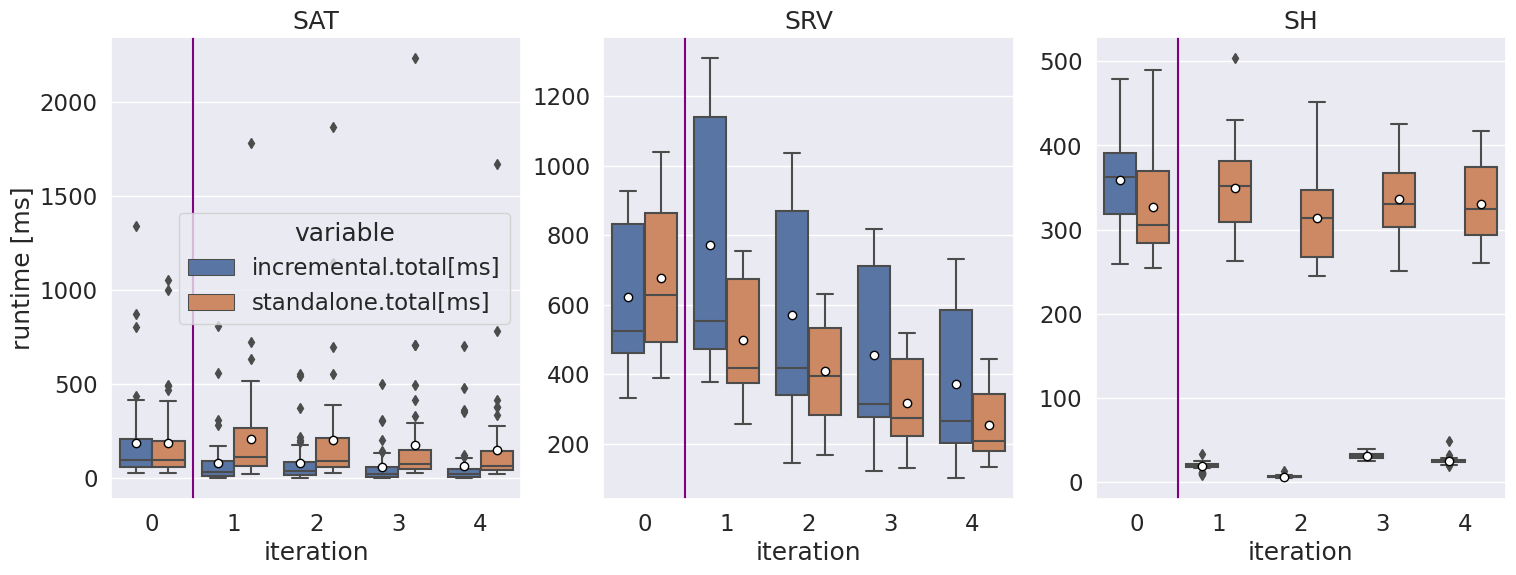

In [4]:
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.total[ms]','standalone.total[ms]'])
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}

fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle(None)
subplot(axes[0], 'SAT', 'runtime [ms]', True)
subplot(axes[1], 'SRV', None, False)
subplot(axes[2], 'SH', None, False)
fig.savefig("figures/incremental_reduced.pdf", bbox_inches='tight')



In [29]:
tmp = df_incremental.groupby(['iteration', 'prefix']).max(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]'
]]
tmp.sort_values(by=['prefix', 'iteration'])

,prefix,iteration,incremental.total[ms]
0,SAT,0,1340.093985
3,SAT,1,812.654608
6,SAT,2,555.803111
9,SAT,3,504.314615
12,SAT,4,705.056184
1,SH,0,478.537785
4,SH,1,33.113202
7,SH,2,13.193083
10,SH,3,38.812461
13,SH,4,48.630101


In [31]:
df = df_incremental

tmp = df.groupby(['iteration', 'prefix']).mean(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]',#'incremental.sync[ms]','incremental.prop[ms]',
    'standalone.total[ms]'#, 'standalone.sync[ms]', 'standalone.prop[ms]'
]]
tmp['Total reduction %'] = ((tmp['incremental.total[ms]'] / tmp['standalone.total[ms]'])-1)*100
tmp.sort_values(by=['prefix', 'iteration'])

,prefix,iteration,incremental.total[ms],standalone.total[ms],Total reduction %
0,SAT,0,185.949336,187.236812,-0.687619
3,SAT,1,81.447468,209.067680,-61.042535
6,SAT,2,83.262477,204.060684,-59.197198
9,SAT,3,58.192614,179.070568,-67.502971
12,SAT,4,65.339924,151.128067,-56.765196
1,SH,0,358.497804,326.263905,9.879701
4,SH,1,18.491731,349.961405,-94.716066
7,SH,2,6.198011,313.264614,-98.021477
10,SH,3,30.969072,336.336202,-90.792228
13,SH,4,25.117098,330.316779,-92.396057


## Runtime breakdown

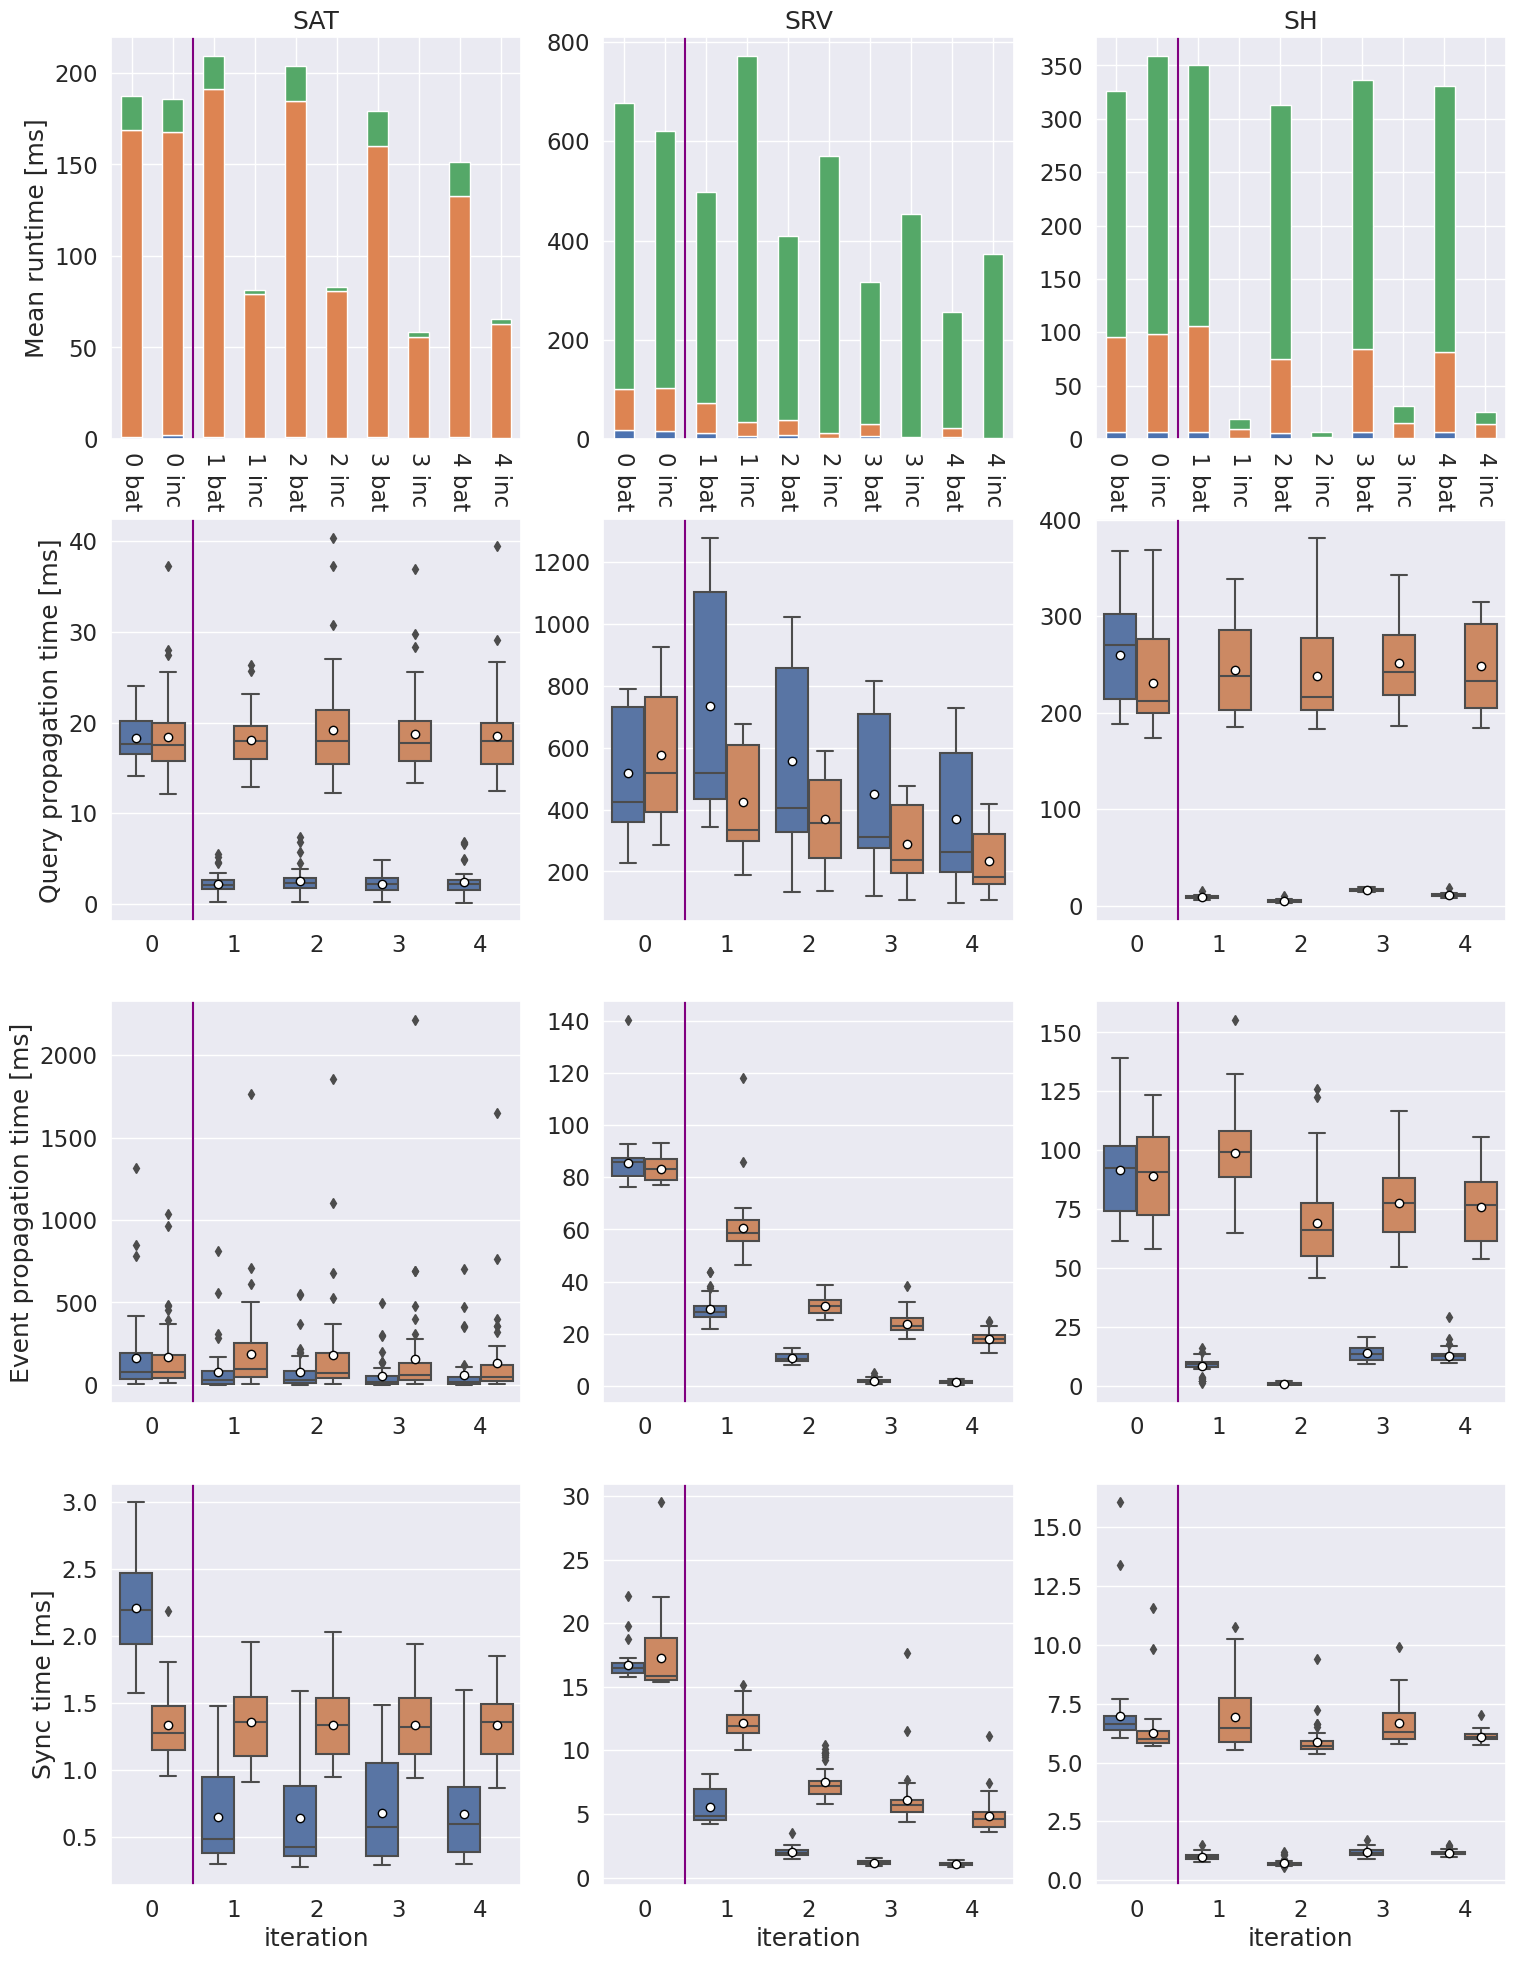

In [30]:
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}


def subBoxPlot(df, ax, case, ylabel=None, xlabel=None, legend=False, title=None, dfx_name="iteration", dfy_name="value", hue="variable"):
    sns.boxplot(ax=ax, data=df[df['prefix']==case], x=dfx_name, y=dfy_name, hue=hue, showmeans=True, meanprops=meanprops)
    ax.set(title=title, ylabel=ylabel, xlabel=xlabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(0.5,0,1,color='purple')

def subBarChart(df, ax, case, ylabel=None, xlabel=None, legend=False, title=None, dfx_name="iteration", dfy_name=['sync[ms]','prop[ms]','engine[ms]']):
    df[df['prefix']==case].plot(kind='bar',ax=ax, x=dfx_name,y=dfy_name,stacked=True)
    ax.tick_params(axis='x', labelrotation=-90)
    ax.set(title=title, ylabel=ylabel, xlabel=xlabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(1.5,0,1,color='purple')
    
fig, axes = plt.subplots(4, 3, figsize=(18,24))
fig.suptitle(None)

df.groupby(['prefix', 'iteration']).median()

# Mean relative breakdown
short=df.groupby(['prefix', 'iteration']).aggregate('mean').reset_index()
short_inc = pd.melt(df, id_vars=['prefix','iteration'],
           value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'])
short_inc['type']='inc'
short_sa = pd.melt(df, id_vars=['prefix','iteration'],
            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'])
short_sa['type']='bat'

short = pd.concat([short_sa,short_inc],ignore_index=True)
short['variable']=short['variable'].map({
                 'incremental.engine[ms]':'engine[ms]',
                 'incremental.sync[ms]':'sync[ms]',
                 'incremental.prop[ms]':'prop[ms]',
                 'standalone.engine[ms]':'engine[ms]',
                 'standalone.sync[ms]':'sync[ms]',
                 'standalone.prop[ms]':'prop[ms]'
})
short = short.pivot_table(index=['prefix','iteration','type'], columns='variable')['value'].reset_index()
short['iteration'] = short['iteration'].astype(str)+' '+short['type']

subBarChart(short, axes[0,0], 'SAT', title='SAT', ylabel='Mean runtime [ms]')
subBarChart(short, axes[0,1], 'SRV', title='SRV')
subBarChart(short, axes[0,2], 'SH', title='SH')

# Query propagation
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.engine[ms]','standalone.engine[ms]'])
subBoxPlot(short, axes[1,0], 'SAT', ylabel='Query propagation time [ms]')
subBoxPlot(short, axes[1,1], 'SRV')
subBoxPlot(short, axes[1,2], 'SH')

# Event propagation time
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.prop[ms]','standalone.prop[ms]'])
subBoxPlot(short, axes[2,0], 'SAT', ylabel='Event propagation time [ms]')
subBoxPlot(short, axes[2,1], 'SRV')
subBoxPlot(short, axes[2,2], 'SH')

#Sync time
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.sync[ms]','standalone.sync[ms]'])
subBoxPlot(short, axes[3,0], 'SAT', xlabel='iteration', ylabel='Sync time [ms]')
subBoxPlot(short, axes[3,1], 'SRV', xlabel='iteration')
subBoxPlot(short, axes[3,2], 'SH', xlabel='iteration')



fig.savefig("figures/eval-sync.pdf", bbox_inches='tight')

In [38]:
# Mean subtask times
df = df_incremental

tmp = df.groupby(['iteration', 'prefix']).mean(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]', 'incremental.engine[ms]', 'incremental.sync[ms]','incremental.prop[ms]',
    'standalone.total[ms]', 'standalone.engine[ms]', 'standalone.sync[ms]', 'standalone.prop[ms]'
]]
tmp['Total reduction %'] = ((tmp['incremental.total[ms]'] / tmp['standalone.total[ms]'])-1)*100
tmp['Engine reduction %'] = ((tmp['incremental.engine[ms]'] / tmp['standalone.engine[ms]'])-1)*100
tmp['Sync reduction %'] = ((tmp['incremental.sync[ms]'] / tmp['standalone.sync[ms]'])-1)*100
tmp['Prop reduction %'] = ((tmp['incremental.prop[ms]'] / tmp['standalone.prop[ms]'])-1)*100
tmp.sort_values(by=['prefix', 'iteration'])#[['prefix', 'iteration','Total reduction %']]

,prefix,iteration,incremental.total[ms],incremental.engine[ms],incremental.sync[ms],incremental.prop[ms],standalone.total[ms],standalone.engine[ms],standalone.sync[ms],standalone.prop[ms],Total reduction %,Engine reduction %,Sync reduction %,Prop reduction %
0,SAT,0,185.95,18.26,2.21,165.48,187.24,18.38,1.34,167.52,-0.69,-0.61,64.95,-1.22
3,SAT,1,81.45,2.26,0.65,78.53,209.07,18.04,1.36,189.68,-61.04,-87.44,-52.02,-58.60
6,SAT,2,83.26,2.53,0.64,80.09,204.06,19.14,1.34,183.58,-59.20,-86.78,-52.10,-56.37
9,SAT,3,58.19,2.19,0.68,55.32,179.07,18.79,1.34,158.95,-67.50,-88.33,-49.17,-65.20
12,SAT,4,65.34,2.41,0.67,62.26,151.13,18.55,1.33,131.24,-56.77,-87.02,-49.91,-52.56
1,SH,0,358.50,260.06,7.00,91.45,326.26,230.81,6.26,89.18,9.88,12.67,11.66,2.54
4,SH,1,18.49,8.86,1.00,8.63,349.96,244.13,6.93,98.90,-94.72,-96.37,-85.61,-91.27
7,SH,2,6.20,4.56,0.73,0.91,313.26,238.39,5.86,69.02,-98.02,-98.09,-87.59,-98.69
10,SH,3,30.97,15.99,1.18,13.80,336.34,251.97,6.70,77.67,-90.79,-93.65,-82.35,-82.23
13,SH,4,25.12,11.02,1.16,12.94,330.32,248.36,6.10,75.85,-92.40,-95.56,-80.98,-82.94


## Appendix data

In [32]:
satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])
srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])
shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])

pd.set_option('display.precision', 2)
print('% Sync times')
for i in range(0,5):
    satIMean = satdata['incremental.sync[ms]']['mean'][i]
    satBMean = satdata['standalone.sync[ms]']['mean'][i]
    srvIMean = srvdata['incremental.sync[ms]']['mean'][i]
    srvBMean = srvdata['standalone.sync[ms]']['mean'][i]
    shIMean = shdata['incremental.sync[ms]']['mean'][i]
    shBMean = shdata['standalone.sync[ms]']['mean'][i]
    print(f"\t\t{i} & {satIMean:.2f} & {satBMean:.2f} & {srvIMean:.2f} & {srvBMean:.2f} & {shIMean:.2f} & {shBMean:.2f} \\\\ %")
    satR = (satIMean/satBMean)-1
    srvR = (srvIMean/srvBMean)-1
    shR = (shIMean/shBMean)-1
    print(f'% \t\tSAT: {satR:.2%}; SRV: {srvR:.2%}; SH: {shR:.2%}')
    print('\t\\hline %')

% Sync times
		0 & 2.21 & 1.34 & 16.68 & 17.29 & 7.00 & 6.26 \\ %
% 		SAT: 64.95%; SRV: -3.51%; SH: 11.66%
	\hline %
		1 & 0.65 & 1.36 & 5.55 & 12.14 & 1.00 & 6.93 \\ %
% 		SAT: -52.02%; SRV: -54.26%; SH: -85.61%
	\hline %
		2 & 0.64 & 1.34 & 2.01 & 7.48 & 0.73 & 5.86 \\ %
% 		SAT: -52.10%; SRV: -73.18%; SH: -87.59%
	\hline %
		3 & 0.68 & 1.34 & 1.18 & 6.08 & 1.18 & 6.70 \\ %
% 		SAT: -49.17%; SRV: -80.59%; SH: -82.35%
	\hline %
		4 & 0.67 & 1.33 & 1.08 & 4.82 & 1.16 & 6.10 \\ %
% 		SAT: -49.91%; SRV: -77.68%; SH: -80.98%
	\hline %


/tmp/ipykernel_75772/1824453194.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])
/tmp/ipykernel_75772/1824453194.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])
/tmp/ipykernel_75772/1824453194.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.sync[ms]','standalone.sync[ms]'].agg(['mean','median'])


In [5]:
satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])
srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])
shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])

pd.set_option('display.precision', 2)

for i in range(0,5):
    satIMean = satdata['incremental.total[ms]']['mean'][i]
    satBMean = satdata['standalone.total[ms]']['mean'][i]
    srvIMean = srvdata['incremental.total[ms]']['mean'][i]
    srvBMean = srvdata['standalone.total[ms]']['mean'][i]
    shIMean = shdata['incremental.total[ms]']['mean'][i]
    shBMean = shdata['standalone.total[ms]']['mean'][i]
    print(f"\t\t{i} & {satIMean:.2f} & {satBMean:.2f} & {srvIMean:.2f} & {srvBMean:.2f} & {shIMean:.2f} & {shBMean:.2f} \\\\ %")
    print('\t\\hline %')


		0 & 185.95 & 187.24 & 621.46 & 676.39 & 358.50 & 326.26 \\ %
	\hline %
		1 & 81.45 & 209.07 & 771.17 & 498.15 & 18.49 & 349.96 \\ %
	\hline %
		2 & 83.26 & 204.06 & 570.46 & 409.10 & 6.20 & 313.26 \\ %
	\hline %
		3 & 58.19 & 179.07 & 454.17 & 317.14 & 30.97 & 336.34 \\ %
	\hline %
		4 & 65.34 & 151.13 & 372.32 & 255.36 & 25.12 & 330.32 \\ %
	\hline %


/tmp/ipykernel_32535/4168162562.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])
/tmp/ipykernel_32535/4168162562.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])
/tmp/ipykernel_32535/4168162562.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.total[ms]','standalone.total[ms]'].agg(['mean','median'])


In [11]:
satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])
srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])
shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])

pd.set_option('display.precision', 2)
print('% Query propagation times')
for i in range(0,5):
    satIMean = satdata['incremental.engine[ms]']['mean'][i]
    satBMean = satdata['standalone.engine[ms]']['mean'][i]
    srvIMean = srvdata['incremental.engine[ms]']['mean'][i]
    srvBMean = srvdata['standalone.engine[ms]']['mean'][i]
    shIMean = shdata['incremental.engine[ms]']['mean'][i]
    shBMean = shdata['standalone.engine[ms]']['mean'][i]
    print(f"\t\t{i} & {satIMean:.2f} & {satBMean:.2f} & {srvIMean:.2f} & {srvBMean:.2f} & {shIMean:.2f} & {shBMean:.2f} \\\\ %")
    satR = (satIMean/satBMean)-1
    srvR = (srvIMean/srvBMean)-1
    shR = (shIMean/shBMean)-1
    print(f'% \t\tSAT: {satR:.2%}; SRV: {srvR:.2%}; SH: {shR:.2%}')
    print('\t\\hline %')

% Query propagation times
		0 & 18.26 & 18.38 & 519.07 & 576.05 & 260.06 & 230.81 \\ %
% 		SAT: -0.61%; SRV: -9.89%; SH: 12.67%
	\hline %
		1 & 2.26 & 18.04 & 736.29 & 425.33 & 8.86 & 244.13 \\ %
% 		SAT: -87.44%; SRV: 73.11%; SH: -96.37%
	\hline %
		2 & 2.53 & 19.14 & 557.68 & 370.82 & 4.56 & 238.39 \\ %
% 		SAT: -86.78%; SRV: 50.39%; SH: -98.09%
	\hline %
		3 & 2.19 & 18.79 & 451.05 & 287.32 & 15.99 & 251.97 \\ %
% 		SAT: -88.33%; SRV: 56.99%; SH: -93.65%
	\hline %
		4 & 2.41 & 18.55 & 369.77 & 232.48 & 11.02 & 248.36 \\ %
% 		SAT: -87.02%; SRV: 59.05%; SH: -95.56%
	\hline %


/tmp/ipykernel_32535/3501113314.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  satdata = (df[df['prefix']=='SAT']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])
/tmp/ipykernel_32535/3501113314.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  srvdata = (df[df['prefix']=='SRV']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])
/tmp/ipykernel_32535/3501113314.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  shdata = (df[df['prefix']=='SH']).groupby(['iteration'])['incremental.engine[ms]','standalone.engine[ms]'].agg(['mean','median'])


In [12]:
short=df.groupby(['prefix', 'iteration']).aggregate('mean').reset_index()
#short_inc = pd.melt(df, id_vars=['prefix','iteration'],
#            value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'],
#            var_name='inc-var', value_name='inc-val')
#short_sa = pd.melt(df, id_vars=['prefix','iteration'],
#            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'],
#            var_name='std-var', value_name='std-val')

short_inc = pd.melt(df, id_vars=['prefix','iteration'],
           value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'])
short_inc['type']='inc'
short_sa = pd.melt(df, id_vars=['prefix','iteration'],
            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'])
short_sa['type']='bat'

short = pd.concat([short_sa,short_inc],ignore_index=True)
short['variable']=short['variable'].map({'incremental.engine[ms]':'engine[ms]',
                 'incremental.sync[ms]':'sync[ms]',
                 'incremental.prop[ms]':'prop[ms]',
                 'standalone.engine[ms]':'engine[ms]',
                 'standalone.sync[ms]':'sync[ms]',
                 'standalone.prop[ms]':'prop[ms]'})
short = short.pivot_table(index=['prefix','iteration','type'], columns='variable')['value'].reset_index()
short['iteration'] = short['iteration'].astype(str)+' '+short['type']

In [14]:
print('SAT - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SAT - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')

print('SRV - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SRV - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')

print('SH - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SH - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')


SAT - inc
0 - Query: 9.82%; Event: 88.99%; Synt: 1.19%
1 - Query: 2.78%; Event: 96.42%; Synt: 0.80%
2 - Query: 3.04%; Event: 96.19%; Synt: 0.77%
3 - Query: 3.77%; Event: 95.06%; Synt: 1.17%
4 - Query: 3.69%; Event: 95.29%; Synt: 1.02%
SAT - batch
0 - Query: 9.81%; Event: 89.47%; Synt: 0.71%
1 - Query: 8.63%; Event: 90.73%; Synt: 0.65%
2 - Query: 9.38%; Event: 89.96%; Synt: 0.66%
3 - Query: 10.49%; Event: 88.76%; Synt: 0.75%
4 - Query: 12.27%; Event: 86.84%; Synt: 0.88%
SRV - inc
0 - Query: 83.52%; Event: 13.79%; Synt: 2.68%
1 - Query: 95.48%; Event: 3.80%; Synt: 0.72%
2 - Query: 97.76%; Event: 1.89%; Synt: 0.35%
3 - Query: 99.31%; Event: 0.43%; Synt: 0.26%
4 - Query: 99.31%; Event: 0.40%; Synt: 0.29%
SRV - batch
0 - Query: 85.16%; Event: 12.28%; Synt: 2.56%
1 - Query: 85.38%; Event: 12.18%; Synt: 2.44%
2 - Query: 90.64%; Event: 7.53%; Synt: 1.83%
3 - Query: 90.59%; Event: 7.49%; Synt: 1.92%
4 - Query: 91.04%; Event: 7.07%; Synt: 1.89%
SH - inc
0 - Query: 72.54%; Event: 25.51%; Synt: 1.